<a href="https://colab.research.google.com/github/Tiagoeem/Ensaio_Sobre_o_AutoML/blob/main/Auto_ML_PyCaret_Customizado_Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando PyCaret

Instalando módulos para suporte a GPU, treinamento demorou demais nos primeiros testes. [PyCaret on GPU](https://pycaret.readthedocs.io/en/latest/installation.html)

In [ ]:
!pip install -U pandas-profiling

In [ ]:
!pip install pycaret==2.2.3

In [3]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


# Nota

Este notebook irá testar a performance da biblioteca Pycaret, será testado também a biblioteca H2O.ai em outro notebook ().

# Heart Disease UCI

O conjunto de teste será o famoso Heart Disease da UCI: https://archive.ics.uci.edu/ml/datasets/Heart+Disease


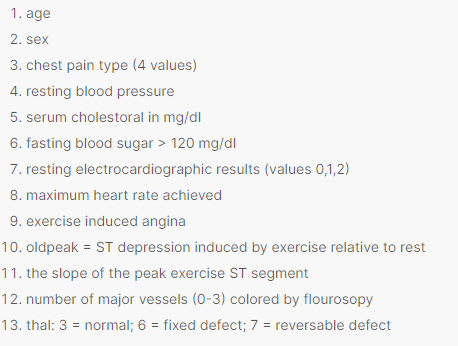

In [4]:
# Baixa o csv a partir de um link para que qualquer pessoa possa executar sem maiores dificuldades
# Uniformiza o trabalho e facilita o compartilhamento de códigos e notebooks
# Realiza o download dos dados e extrai para uma pasta conhecida
import zipfile
import gdown
import os

parent_dir = '/content'

file_name = 'heart.csv'
output = os.path.join( parent_dir, file_name )

if not(os.path.isfile(output)):
    url = 'https://drive.google.com/u/0/uc?id=14DQfvBt2DLX-14DRfCWaxdNjWIq6xkx4'
    gdown.download(url, output=output, quiet=True)


In [5]:
import pandas as pd

df_heart = pd.read_csv('heart.csv')
df_heart.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145,233,1,0,150,0,2.3,0,0,1,yes
1,37,male,2,130,250,0,1,187,0,3.5,0,0,2,yes
2,41,female,1,130,204,0,0,172,0,1.4,2,0,2,yes


In [6]:
df_heart.shape

(303, 14)

# Análise Exploratória de Dados (EDA)

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_heart)
profile.to_notebook_iframe()

# Separação de dados

Por padrão o Pycaret separa os dados em Treino e teste (70%, 30%). Mas uma boa pratica é remover de 5% a 10% dos dados para uma validação final após finalização de todo o processo de modelagem e treinamento.

In [8]:
df_validacao_final = df_heart.sample(frac=0.05, random_state=777)
df_heart.drop(df_validacao_final.index, inplace=True)
df_heart.reset_index(inplace=True, drop=True)

In [9]:
print(df_heart.shape)
print(df_validacao_final.shape)

(288, 14)
(15, 14)


# Pycaret com Parâmetros Default

The **setup()** function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. **setup()** must be called before executing any other function in pycaret. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)



## Customização/Habilitando as configurações ([doc](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Intermediate%20-%20CLF102.ipynb))
- **Normalization**: Normalization / Scaling (often used interchangeably with standardization) is used to transform the actual values of numeric variables in a way that provides helpful properties for machine learning. Many algorithms such as Logistic Regression, Support Vector Machine, K Nearest Neighbors and Naive Bayes assume that all features are centered around zero and have variances that are at at the same level of order. If a particular feature in a dataset has a variance that is larger in order of magnitude than other features, the model may not understand all features correctly and could perform poorly. For instance, in the dataset we are using for this example the AGE feature ranges between 21 to 79 while other numeric features range from 10,000 to 1,000,000.

- **Transformation**: While normalization transforms the range of data to remove the impact of magnitude in variance, transformation is a more radical technique as it changes the shape of the distribution so that transformed data can be represented by a normal or approximate normal distirbution. In general, you should transform the data if using algorithms that assume normality or a gaussian distribution. Examples of such models are Logistic Regression, Linear Discriminant Analysis (LDA) and Gaussian Naive Bayes. (Pro tip: any method with “Gaussian” in the name probably assumes normality.)

- **Ignore Low Variance**: Datasets can sometimes contain categorical features that have a single unique or small number of values across samples. This kind of features are not only non-informative and add no value but are also sometimes harmful for few algorithms. Imagine a feature with only one unique value or few dominant unique values accross samples, they can be removed from the dataset by using the ignore low variance feature in PyCaret.

- **Multi-collinearity**: Multi-collinearity is a state of very high intercorrelations or inter-associations among the independent features in the dataset. It is a type of disturbance in the data that is not handled well by machine learning models (mostly linear algorithms). Multi-collinearity may reduce overall coefficient of the model and cause unpredictable variance. This will lead to overfitting where the model may do great on a known training set but will fail with an unknown testing set.

- **Group Features**: Sometimes datasets may contain features that are related at a sample level. For example in the credit dataset there are features called BILL_AMT1 .. BILL_AMT6 which are related in such a way that BILL_AMT1 is the amount of the bill 1 month ago and BILL_AMT6 is the amount of the bill 6 months ago. Such features can be used to extract additional features based on the statistical properties of the distribution such as mean, median, variance, standard deviation etc.

- **Bin Numeric Variables**: Binning or discretization is the process of transforming numerical variables into categorical features. An example would be the Age variable which is a continious distribution of numeric values that can be discretized into intervals (10-20 years, 21-30 etc.). Binning may improve the accuracy of a predictive model by reducing the noise or non-linearity in the data. PyCaret automatically determines the number and size of bins using Sturges rule.


In [10]:
from pycaret.classification import *

clf_default = setup(df_heart, target = 'target', session_id=1, log_experiment=True, experiment_name='Pycaret Customizado Values',
                    normalize = True, 
                    transformation = True, 
                    ignore_low_variance = True,
                    bin_numeric_features = ['age'],
                    remove_multicollinearity = True, multicollinearity_threshold = 0.95)

,Description,Value
0,session_id,1
1,Target,target
2,Target Type,Binary
3,Label Encoded,"no: 0, yes: 1"
4,Original Data,"(288, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparando modelos

 
"Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case)." [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [11]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8510,0.0000,0.9023,0.8535,0.8708,0.6941,0.7108,0.017
lr,Logistic Regression,0.8460,0.9202,0.8841,0.8583,0.8641,0.6851,0.7023,0.120
lda,Linear Discriminant Analysis,0.8410,0.9078,0.8932,0.8439,0.8614,0.6741,0.6914,0.019
catboost,CatBoost Classifier,0.8310,0.9054,0.8659,0.8512,0.8522,0.6539,0.6681,1.432
lightgbm,Light Gradient Boosting Machine,0.8210,0.8875,0.8394,0.8542,0.8416,0.6318,0.6416,0.070
ada,Ada Boost Classifier,0.8162,0.8717,0.8303,0.8474,0.8333,0.6274,0.6381,0.095
et,Extra Trees Classifier,0.8114,0.8813,0.8295,0.8492,0.8307,0.6141,0.6287,0.445
gbc,Gradient Boosting Classifier,0.8112,0.8958,0.8583,0.8251,0.8356,0.6133,0.6267,0.083
knn,K Neighbors Classifier,0.8110,0.8892,0.8295,0.8411,0.8300,0.6147,0.6265,0.119
rf,Random Forest Classifier,0.8110,0.9016,0.8568,0.8248,0.8347,0.6124,0.6264,0.462


## Criando Modelos Individuais (2: Cat e RandomForest)

### CatBoost

In [12]:
# CatBoost
catboost = create_model(estimator='catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.7870,1.0000,0.7500,0.8571,0.5882,0.6455
1,0.9000,0.9394,0.9091,0.9091,0.9091,0.7980,0.7980
2,0.8500,0.9293,0.7273,1.0000,0.8421,0.7059,0.7385
3,0.8500,0.8687,0.8182,0.9000,0.8571,0.7000,0.7035
4,0.8000,0.9596,0.8182,0.8182,0.8182,0.5960,0.5960
5,0.8000,0.8687,0.9091,0.7692,0.8333,0.5876,0.6005
6,0.9500,0.9899,0.9091,1.0000,0.9524,0.9000,0.9045
7,0.7500,0.9192,0.9091,0.7143,0.8000,0.4792,0.5044
8,0.8500,0.9798,0.9091,0.8333,0.8696,0.6939,0.6975
9,0.7500,0.8125,0.7500,0.8182,0.7826,0.4898,0.4924


### Ridge Classifier

In [32]:
# Ridge Classifier
random_ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.0,1.0000,0.7500,0.8571,0.5882,0.6455
1,0.9000,0.0,0.9091,0.9091,0.9091,0.7980,0.7980
2,0.8500,0.0,0.7273,1.0000,0.8421,0.7059,0.7385
3,0.8500,0.0,0.8182,0.9000,0.8571,0.7000,0.7035
4,0.9000,0.0,1.0000,0.8462,0.9167,0.7938,0.8112
5,0.7000,0.0,0.8182,0.6923,0.7500,0.3814,0.3898
6,0.9500,0.0,1.0000,0.9167,0.9565,0.8980,0.9027
7,0.8500,0.0,1.0000,0.7857,0.8800,0.6875,0.7237
8,0.9500,0.0,1.0000,0.9167,0.9565,0.8980,0.9027
9,0.7500,0.0,0.7500,0.8182,0.7826,0.4898,0.4924


## Tunando os Modelos

By default, tune_model optimizes Accuracy but this can be changed using optimize parameter. For example: tune_model(dt, optimize = 'AUC') will search for the hyperparameters of a Decision Tree Classifier that results in the highest AUC instead of Accuracy. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

### CatBoost

In [33]:
tuned_cat = tune_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.7407,1.0000,0.7500,0.8571,0.5882,0.6455
1,0.9000,0.9293,0.9091,0.9091,0.9091,0.7980,0.7980
2,0.8500,0.8990,0.7273,1.0000,0.8421,0.7059,0.7385
3,0.8500,0.8586,0.8182,0.9000,0.8571,0.7000,0.7035
4,0.8500,0.9697,0.9091,0.8333,0.8696,0.6939,0.6975
5,0.8000,0.8990,0.9091,0.7692,0.8333,0.5876,0.6005
6,0.9500,0.9798,0.9091,1.0000,0.9524,0.9000,0.9045
7,0.8000,0.9596,1.0000,0.7333,0.8462,0.5789,0.6383
8,0.9500,0.9899,0.9091,1.0000,0.9524,0.9000,0.9045
9,0.7000,0.7812,0.7500,0.7500,0.7500,0.3750,0.3750


### Ridge Classifier

In [51]:
tuned_rg = tune_model(random_ridge)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.0,1.0000,0.7500,0.8571,0.5882,0.6455
1,0.9000,0.0,0.9091,0.9091,0.9091,0.7980,0.7980
2,0.9000,0.0,0.8182,1.0000,0.9000,0.8020,0.8182
3,0.8500,0.0,0.8182,0.9000,0.8571,0.7000,0.7035
4,0.9000,0.0,1.0000,0.8462,0.9167,0.7938,0.8112
5,0.7000,0.0,0.7273,0.7273,0.7273,0.3939,0.3939
6,0.9500,0.0,1.0000,0.9167,0.9565,0.8980,0.9027
7,0.8000,0.0,1.0000,0.7333,0.8462,0.5789,0.6383
8,0.9000,0.0,1.0000,0.8462,0.9167,0.7938,0.8112
9,0.7500,0.0,0.7500,0.8182,0.7826,0.4898,0.4924


## Validando os modelos (Métricas e Gráficos)


### Catboost

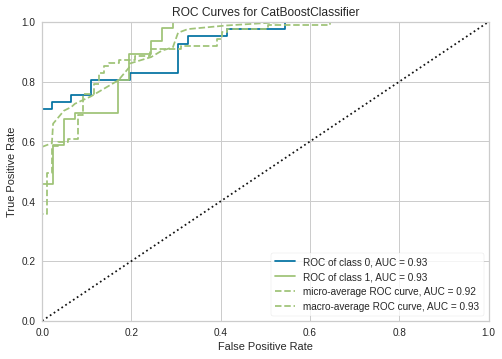

In [52]:
plot_model(tuned_cat, plot='auc')

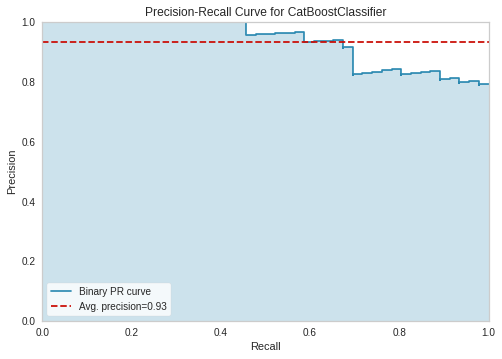

In [53]:
plot_model(tuned_cat, plot = 'pr')

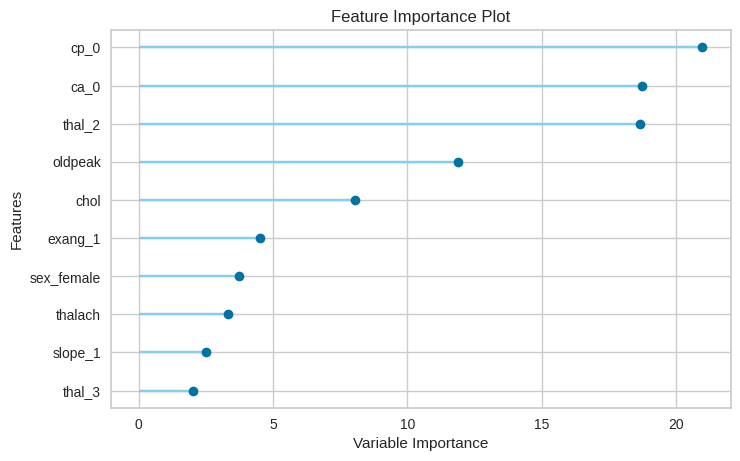

In [54]:
plot_model(tuned_cat, plot='feature')

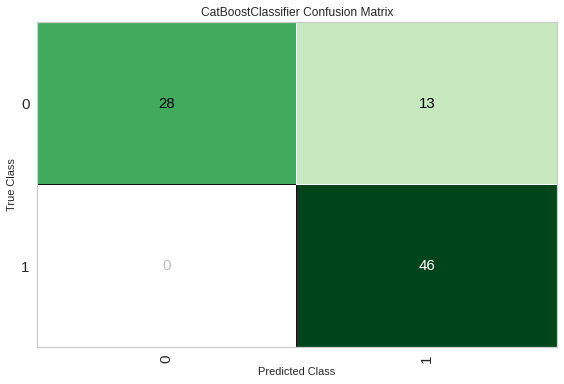

In [55]:
plot_model(tuned_cat, plot = 'confusion_matrix')

### Ridge Classifier

A função **evaluate_model()** inicia uma interface de usuário que permite a seleção do tipo de gráfico, permitindo a validação do modelo com todos as métricas disponíveis pelo PyCaret.

In [56]:
evaluate_model(tuned_rg)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Avaliando os conjunto de **Teste**

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

### CatBoost

In [57]:
predict_model(tuned_cat).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8506,0.9268,1.0,0.7797,0.8762,0.6949,0.7297


,trestbps,chol,thalach,oldpeak,sex_female,cp_0,cp_1,cp_2,cp_3,fbs_0,restecg_1,restecg_2,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,target,Label,Score
0,0.405404,1.297677,-0.061051,-1.148419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no,yes,0.7995
1,0.791553,-0.947686,-1.060982,0.138295,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,no,no,0.7206
2,-0.582983,-1.275467,-1.475754,0.602146,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,no,0.8325
3,0.189132,0.857733,0.274161,-1.148419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,yes,yes,0.7204
4,0.073245,-0.076059,1.089444,-1.148419,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no,yes,0.8085


### Ridge Classifier

In [58]:
predict_model(tuned_rg).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8391,0.8332,0.9348,0.7963,0.86,0.6736,0.6857


,trestbps,chol,thalach,oldpeak,sex_female,cp_0,cp_1,cp_2,cp_3,fbs_0,restecg_1,restecg_2,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,target,Label
0,0.405404,1.297677,-0.061051,-1.148419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no,yes
1,0.791553,-0.947686,-1.060982,0.138295,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,no,no
2,-0.582983,-1.275467,-1.475754,0.602146,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,no
3,0.189132,0.857733,0.274161,-1.148419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,yes,yes
4,0.073245,-0.076059,1.089444,-1.148419,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no,yes


## Realizando a Calibração dos Modelos

Verificar se existe melhora.

In [59]:
best_calib = calibrate_model(tuned_rg)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.8148,1.0000,0.7500,0.8571,0.5882,0.6455
1,0.9000,0.9697,0.9091,0.9091,0.9091,0.7980,0.7980
2,0.8500,0.9495,0.7273,1.0000,0.8421,0.7059,0.7385
3,0.8500,0.9091,0.8182,0.9000,0.8571,0.7000,0.7035
4,0.9000,0.9899,1.0000,0.8462,0.9167,0.7938,0.8112
5,0.7500,0.8283,0.7273,0.8000,0.7619,0.5000,0.5025
6,0.9500,0.9798,1.0000,0.9167,0.9565,0.8980,0.9027
7,0.8500,1.0000,1.0000,0.7857,0.8800,0.6875,0.7237
8,0.9500,1.0000,1.0000,0.9167,0.9565,0.8980,0.9027
9,0.7500,0.8229,0.7500,0.8182,0.7826,0.4898,0.4924


In [60]:
predict_model(best_calib).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8391,0.956,0.9348,0.7963,0.86,0.6736,0.6857


,trestbps,chol,thalach,oldpeak,sex_female,cp_0,cp_1,cp_2,cp_3,fbs_0,restecg_1,restecg_2,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,target,Label,Score
0,0.405404,1.297677,-0.061051,-1.148419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no,yes,0.7290
1,0.791553,-0.947686,-1.060982,0.138295,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,no,no,0.8288
2,-0.582983,-1.275467,-1.475754,0.602146,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,no,0.8212
3,0.189132,0.857733,0.274161,-1.148419,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,yes,yes,0.7694
4,0.073245,-0.076059,1.089444,-1.148419,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no,yes,0.7107


## Finalizando o modelo

Modelo escolhido: Ridge

The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [61]:
final = finalize_model(best_calib)

In [62]:
# Visualizando os parametros do modelo que irá para Deploy
final.get_params()

{'base_estimator': RidgeClassifier(alpha=2.41, class_weight=None, copy_X=True, fit_intercept=True,
                 max_iter=None, normalize=True, random_state=1, solver='auto',
                 tol=0.001),
 'base_estimator__alpha': 2.41,
 'base_estimator__class_weight': None,
 'base_estimator__copy_X': True,
 'base_estimator__fit_intercept': True,
 'base_estimator__max_iter': None,
 'base_estimator__normalize': True,
 'base_estimator__random_state': 1,
 'base_estimator__solver': 'auto',
 'base_estimator__tol': 0.001,
 'cv': StratifiedKFold(n_splits=10, random_state=1, shuffle=False),
 'method': 'sigmoid'}

## Validação dados nunca usados

In [63]:
df_unseen = predict_model(final, data=df_validacao_final)
df_unseen.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Label,Score
136,60,female,2,120,178,1,1,96,0,0.0,2,0,2,yes,yes,0.9143
89,58,female,0,100,248,0,0,122,0,1.0,1,0,2,yes,yes,0.5791
244,56,male,0,132,184,0,0,105,1,2.1,1,1,1,no,no,0.9502
273,58,male,0,100,234,0,1,156,0,0.1,2,1,3,no,no,0.6766
158,58,male,1,125,220,0,1,144,0,0.4,1,4,3,yes,no,0.6193


In [64]:
from pycaret.utils import check_metric

check_metric(df_unseen['target'], df_unseen['Label'], metric = 'Accuracy')

0.8

# Salvando o modelo

In [65]:
save_model(final,'Final_17maio2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                        threshold=0.95)),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  CalibratedClassifierCV(base_estimator=RidgeClassifier(alpha=2.41,
                                

# Loading do Modelo (Exemplo)

In [66]:
modelo_salvo = load_model('/content/Final_17maio2021')

Transformation Pipeline and Model Successfully Loaded


In [67]:
predict_model(modelo_salvo, data=df_unseen)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Label,Score
136,60,female,2,120,178,1,1,96,0,0.0,2,0,2,yes,yes,0.9143
89,58,female,0,100,248,0,0,122,0,1.0,1,0,2,yes,yes,0.5791
244,56,male,0,132,184,0,0,105,1,2.1,1,1,1,no,no,0.9502
273,58,male,0,100,234,0,1,156,0,0.1,2,1,3,no,no,0.6766
158,58,male,1,125,220,0,1,144,0,0.4,1,4,3,yes,no,0.6193
260,66,female,0,178,228,1,1,165,1,1.0,1,2,3,no,no,0.8861
19,69,female,3,140,239,0,1,151,0,1.8,2,2,2,yes,yes,0.7254
249,69,male,2,140,254,0,0,146,0,2.0,1,3,3,no,no,0.8220
25,71,female,1,160,302,0,1,162,0,0.4,2,2,2,yes,yes,0.7949
208,49,male,2,120,188,0,1,139,0,2.0,1,3,3,no,no,0.7381
